In [1]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install vietocr Pillow==9.4.0 ultralytics dill rich tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.9/802.9 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 19.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.9/133.9 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 84.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of vietocr to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/313.5 kB 43.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using

In [3]:
import os
import json
import io
from ultralytics import YOLO
from ultralytics.models.yolo.detect.predict import DetectionPredictor
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg
import torch
from rich import print

In [4]:
# YOLO
sources_model = '/content/drive/MyDrive/best-5.pt'
model = YOLO(sources_model)

In [5]:
names_index = {
    0: 'A-C_number',
    1: 'Add',
    2: 'Add_prefix',
    3: 'Amount',
    4: 'Buyer',
    5: 'Buyer_add',
    6: 'Buyer_company',
    7: 'Buyer_sign',
    8: 'Buyer_tax',
    9: 'Datetime',
    10: 'Fprice',
    11: 'Payment_method',
    12: 'Product',
    13: 'Quanity',
    14: 'Seller_sign',
    15: 'Shop_name',
    16: 'Tprice',
    17: 'Unit',
    18: 'Unit_price',
    19: 'VAT'
}
imgWidth = 640
imgHeight = 480

In [6]:
config_2 = Cfg.load_config_from_name('vgg_transformer')
config_2['device'] = 'cuda' if torch.cuda.is_available() else "cpu"
config_2['predictor']['beamsearch']=False
config_2["weights"] = "/content/drive/MyDrive/transformerocr.pth"
detector = Predictor(config_2)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:10<00:00, 57.4MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch

In [7]:
def deskew(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated


def remove_noise(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    return cv2.fastNlMeansDenoisingColored(blurred, None, 10, 10, 7, 21)


def scale_to_dpi(image, target_dpi):
    current_dpi = 72  # DPI mặc định của OpenCV
    scale_factor = target_dpi / current_dpi
    width = int(image.shape[1] * scale_factor)
    height = int(image.shape[0] * scale_factor)
    scaled_image = cv2.resize(image, (width, height), interpolation=cv2.INTER_LINEAR)
    return scaled_image

def image_processing(crop_img):
    crop_img_np = np.array(crop_img)
    crop_img_np = cv2.cvtColor(crop_img_np, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR format for OpenCV
    gray = cv2.cvtColor(crop_img_np, cv2.COLOR_BGR2GRAY)
    gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    return gray

def ocr(crop_img):
    gray = image_processing(crop_img)
    text = detector.predict(Image.fromarray(gray))
    return text

def get_text(img_path):
    img = Image.open(img_path)
    results = model.predict(source=img_path, verbose=False)

    dic = {key: [] for key in names_index.values()}

    for box in results[0].boxes:
        if int(box.cls[0]) in names_index:
            name = names_index[int(box.cls[0])]
            dic[name].append(box.xyxy[0].cpu().numpy().astype(int))

    res = {key: '' for key in names_index.values()}

    for key, value_list in dic.items():
        combined_text = ''
        for value in value_list:
            crop_img = img.crop(value)
            text = ocr(crop_img)
            combined_text += text + ' '
            print(f"Extracted text for {key}: {text}")  # Debug print
        res[key] = combined_text.strip()

    return res

def detect_bill(img_path):
    # Load image
  img = cv2.imread(img_path)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for displaying correctly with matplotlib

  # Run inference
  results = model(img_rgb)

  # Process and display results
  for result in results:
      result_img = result.plot()  # Get the result image with plotted boxes, masks, etc.

      # Display the result image
      plt.figure(figsize=(12, 12))
      plt.imshow(result_img)
      plt.axis('off')
      plt.show()

FileUpload(value={}, accept='image/*', description='Upload')

Button(description='Detect', style=ButtonStyle())

Button(description='OCR', style=ButtonStyle())


0: 640x640 2 Amounts, 2 Buyer_companys, 1 Datetime, 1 Fprice, 2 Products, 2 Quanitys, 2 Seller_signs, 2 Units, 2 Unit_prices, 85.7ms
Speed: 2.5ms preprocess, 85.7ms inference, 923.6ms postprocess per image at shape (1, 3, 640, 640)


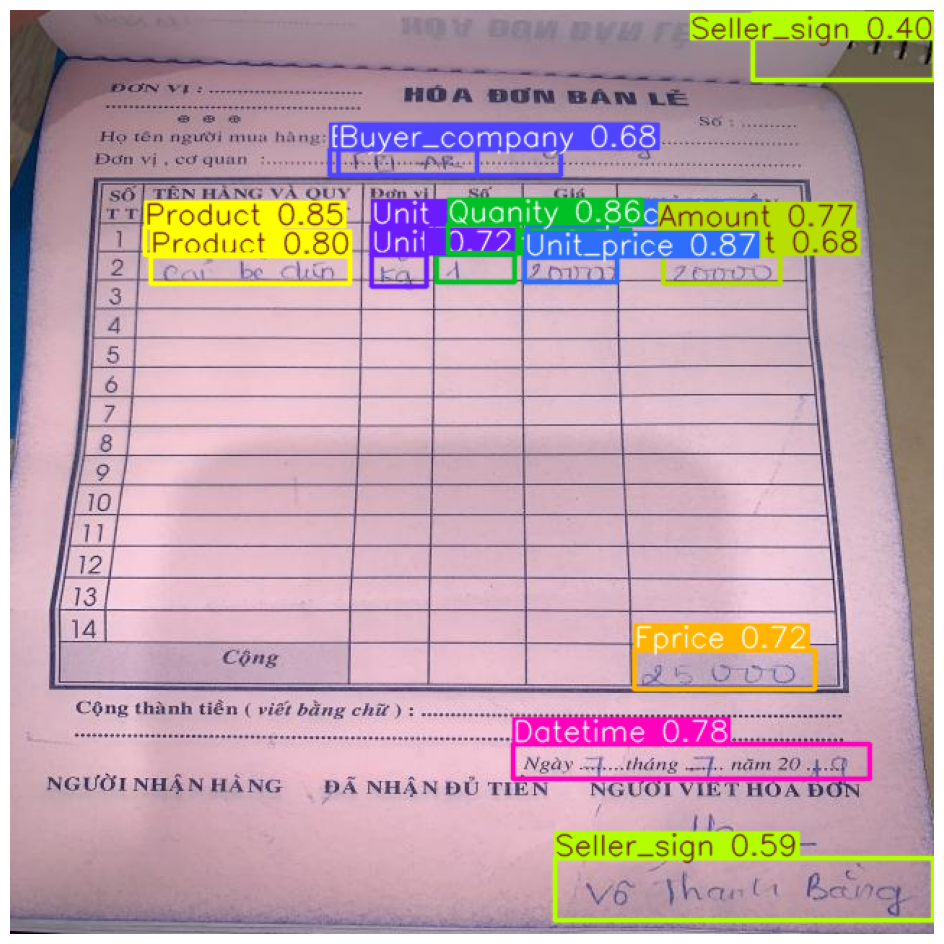

Button(description='Submit', style=ButtonStyle())

Extracted text for Buyer: - Ptr. 14, Ngọ 1 trck Trợp
Extracted text for Fprice: 2000000
Extracted text for Product: Số 5, Tông
Extracted text for Product: Số g, 11 Bị triện
{
    'Buyer': '- Ptr. 14, Ngọ 1 trck Trợp',
    'Fprice': '2000000',
    'Product': 'Số 5, Tông Số g, 11 Bị triện'
}


In [8]:
import ipywidgets as widgets
from IPython.display import display
import io

def handle_upload(change):
    try:
        content = change['new']
        if content:
            file_info = next(iter(content.values()))
            img = Image.open(io.BytesIO(file_info['content']))
            img_path = '/content/uploaded_image.jpg'
            img.save(img_path)
            img_upload.value.clear()  # Reset the file input widget
            # Show action buttons after uploading the image
            display_action_buttons(img_path)
    except Exception as e:
        print(f"Error in handle_upload: {e}")

# Function to display action buttons
def display_action_buttons(img_path):
    # Display action buttons
    display(detect_button)
    display(ocr_button)

# Function to handle "Detect" button click
def on_detect_click(b):
    img_path = '/content/uploaded_image.jpg'
    detect_bill(img_path)

# Function to handle "OCR" button click
def on_ocr_click(b):
    img_path = '/content/uploaded_image.jpg'
    display_class_selection(img_path)

# Function to display class selection checkboxes
def display_class_selection(img_path):
    try:
        # Create and display class checkboxes
        class_checkboxes = [widgets.Checkbox(value=False, description=class_name) for class_name in names_index.values()]
        submit_button_class = widgets.Button(description="Submit")
        display(widgets.VBox(class_checkboxes))
        display(submit_button_class)

        # Function to handle submit button click for class selection
        def on_submit_class(b):
            selected_classes = {checkbox.description for checkbox in class_checkboxes if checkbox.value}
            if selected_classes:
                dic = {key: [] for key in selected_classes}
                text_results = get_text_with_classes(img_path, dic)
                print(text_results)

        submit_button_class.on_click(on_submit_class)
    except Exception as e:
        print(f"Error in display_class_selection: {e}")

# Function to get text with selected classes
def get_text_with_classes(img_path, selected_classes):
    try:
        img = Image.open(img_path)
        results = model.predict(source=img_path, verbose=False)

        dic = {key: [] for key in selected_classes}

        for box in results[0].boxes:
            if int(box.cls[0]) in names_index and names_index[int(box.cls[0])] in selected_classes:
                name = names_index[int(box.cls[0])]
                dic[name].append(box.xyxy[0].cpu().numpy().astype(int))

        res = {key: '' for key in selected_classes}

        for key, value_list in dic.items():
            combined_text = ''
            for value in value_list:
                crop_img = img.crop(value)
                text = ocr(crop_img)
                combined_text += text + ' '
                print(f"Extracted text for {key}: {text}")
            res[key] = combined_text.strip()

        return res
    except Exception as e:
        print(f"Error in get_text_with_classes: {e}")

# Create widgets
img_upload = widgets.FileUpload(accept='image/*', multiple=False)
detect_button = widgets.Button(description="Detect")
ocr_button = widgets.Button(description="OCR")

# Set up button click handlers
detect_button.on_click(on_detect_click)
ocr_button.on_click(on_ocr_click)

# Display the upload widget
display(img_upload)

# Set the handler for the file upload widget
img_upload.observe(handle_upload, names='value')